In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
from suntime import Sun
import pytz

# Helper Functions

In [60]:
def datetime_index(dataframe):
    dataframe.columns = dataframe.columns.str.replace(' ', '')
    dataframe['Datetime'] = pd.to_datetime(dataframe['DateTime'])
    dataframe = dataframe.set_index(['Datetime'])
    del dataframe['DateTime']
    return dataframe

def fill_na(dataframe):
    dataframe['WWCode'] = dataframe['WWCode'].fillna(0).astype(int)
    return dataframe

def day_night(dataframe):

    coordinates = [40.239, 33.029] # Ankara
    dataframe['datetime_col'] = dataframe.index
    
    dataframe["Date"] = dataframe['datetime_col'].apply(pd.to_datetime).dt.date.apply(str)
    dataframe["Hour"] = dataframe['datetime_col'].apply(pd.to_datetime).dt.hour
    dataframe["Month"] = dataframe['datetime_col'].apply(pd.to_datetime).dt.month
    
    sun = Sun(coordinates[0], coordinates[1])
    tz =pytz.timezone('Europe/Istanbul')
    dataframe["Day"]= dataframe[["Date","Hour"]].apply(lambda x : sun.get_local_sunrise_time(pd.to_datetime(x["Date"]).
                                                                date(),local_time_zone=tz).
                                         hour <= x["Hour"] <= sun.get_local_sunset_time(pd.to_datetime(x["Date"]).
                                                                date(),local_time_zone=tz).hour ,axis=1)
    dataframe = dataframe.drop(['Date', 'datetime_col', 'Hour'], axis = 1)
    return dataframe

def wwcode_encoder(dataframe):
    for index, row in dataframe.iterrows():
        if row['WWCode'] < 10:
            dataframe.loc[index, 'WWCode'] = 1
        elif row['WWCode'] < 20:
            dataframe.loc[index, 'WWCode'] = 2
        elif row['WWCode'] < 30:
            dataframe.loc[index, 'WWCode'] = 3
        elif row['WWCode'] < 40:
            dataframe.loc[index, 'WWCode'] = 4
        elif row['WWCode'] < 50:
            dataframe.loc[index, 'WWCode'] = 5
        elif row['WWCode'] < 60:
            dataframe.loc[index, 'WWCode'] = 6
        elif row['WWCode'] < 70:
            dataframe.loc[index, 'WWCode'] = 7
        elif row['WWCode'] < 80:
            dataframe.loc[index, 'WWCode'] = 8
        elif row['WWCode'] < 90:
            dataframe.loc[index, 'WWCode'] = 9
        elif row['WWCode'] < 100:
            dataframe.loc[index, 'WWCode'] = 10
    return dataframe
    
    
def season_encoder(dataframe):
    dataframe['Season'] = 0
    for index, row in dataframe.iterrows():
        if row['Month'] < 3 or row['Month'] == 12:
            dataframe.loc[index, 'Season'] = 1
        elif row['Month'] < 6:
            dataframe.loc[index, 'Season'] = 2
        elif row['Month'] < 9:
            dataframe.loc[index, 'Season'] = 3
        elif row['Month'] < 12:
            dataframe.loc[index, 'Season'] = 4
    return dataframe

def true_false(dataframe):
    for index, row in dataframe.iterrows():
        if row['Day']:
            dataframe.loc[index, 'Day'] = 1
        else:
            dataframe.loc[index, 'Day'] = 0
    return dataframe

# Data Extraction

In [3]:
submission = datetime_index(pd.read_csv('sample_submission.csv'))
label = datetime_index(pd.read_csv('generation.csv', delimiter=';', decimal=','))
features = datetime_index(pd.read_csv('temperature.csv', delimiter=';', decimal=','))

In [4]:
x_train  = fill_na(features.loc['2019-01-01':'2021-11-30'])
x_test = day_night(fill_na(features.loc['2021-12-01':'2021-12-31']))
y_train  = label.loc['2019-01-01':'2021-11-30']
y_test = day_night(submission)

In [5]:
df_train = day_night(pd.concat([ x_train, y_train], axis=1))
df_train.head()

,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover,Generation,Month,Day
Datetime,,,,,,,,,,
2019-01-01 00:00:00,-1.7,-6.1,75.3,3.6,60.0,10,6.3,0.000000,1,False
2019-01-01 01:00:00,-1.8,-5.3,75.3,2.6,70.0,10,4.5,0.000000,1,False
2019-01-01 02:00:00,-2.0,-6.0,74.7,3.1,80.0,10,5.5,0.000008,1,False
2019-01-01 03:00:00,-1.9,-5.9,76.4,3.1,60.0,10,7.6,0.000000,1,False
2019-01-01 04:00:00,-2.0,-7.1,76.4,4.6,60.0,10,6.5,0.000008,1,False


In [6]:
df_train.shape

(25560, 10)

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25560 entries, 2019-01-01 00:00:00 to 2021-11-30 23:00:00
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AirTemperature       25560 non-null  float64
 1   ComfortTemperature   25560 non-null  float64
 2   RelativeHumidity     25560 non-null  float64
 3   WindSpeed            25560 non-null  float64
 4   WindDirection        25560 non-null  float64
 5   WWCode               25560 non-null  int32  
 6   EffectiveCloudCover  25560 non-null  float64
 7   Generation           25560 non-null  float64
 8   Month                25560 non-null  int64  
 9   Day                  25560 non-null  bool   
dtypes: bool(1), float64(7), int32(1), int64(1)
memory usage: 1.9 MB


# Preprocessing

In [8]:
df_train = wwcode_encoder(df_train)
df_train = season_encoder(df_train)

x_test = wwcode_encoder(x_test)
x_test = season_encoder(x_test)

In [9]:
df_train = pd.get_dummies(df_train, columns = ['WWCode'])
x_test = pd.get_dummies(x_test, columns = ['WWCode'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25560 entries, 2019-01-01 00:00:00 to 2021-11-30 23:00:00
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AirTemperature       25560 non-null  float64
 1   ComfortTemperature   25560 non-null  float64
 2   RelativeHumidity     25560 non-null  float64
 3   WindSpeed            25560 non-null  float64
 4   WindDirection        25560 non-null  float64
 5   EffectiveCloudCover  25560 non-null  float64
 6   Generation           25560 non-null  float64
 7   Month                25560 non-null  int64  
 8   Day                  25560 non-null  bool   
 9   Season               25560 non-null  int64  
 10  WWCode_1             25560 non-null  uint8  
 11  WWCode_2             25560 non-null  uint8  
 12  WWCode_3             25560 non-null  uint8  
 13  WWCode_5             25560 non-null  uint8  
 14  WWCode_6             25560 non-null  uint8  
 15  W

In [10]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2021-12-01 00:00:00 to 2021-12-31 23:00:00
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AirTemperature       744 non-null    float64
 1   ComfortTemperature   744 non-null    float64
 2   RelativeHumidity     744 non-null    float64
 3   WindSpeed            744 non-null    float64
 4   WindDirection        744 non-null    float64
 5   EffectiveCloudCover  744 non-null    float64
 6   Month                744 non-null    int64  
 7   Day                  744 non-null    bool   
 8   Season               744 non-null    int64  
 9   WWCode_1             744 non-null    uint8  
 10  WWCode_2             744 non-null    uint8  
 11  WWCode_3             744 non-null    uint8  
 12  WWCode_5             744 non-null    uint8  
 13  WWCode_6             744 non-null    uint8  
 14  WWCode_7             744 non-null    uint8  
 15  WWC

In [11]:
df_train = df_train[~(df_train['WWCode_10'] == 1)]
df_train.drop(['WWCode_10'], axis=1, inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25219 entries, 2019-01-01 00:00:00 to 2021-11-30 23:00:00
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AirTemperature       25219 non-null  float64
 1   ComfortTemperature   25219 non-null  float64
 2   RelativeHumidity     25219 non-null  float64
 3   WindSpeed            25219 non-null  float64
 4   WindDirection        25219 non-null  float64
 5   EffectiveCloudCover  25219 non-null  float64
 6   Generation           25219 non-null  float64
 7   Month                25219 non-null  int64  
 8   Day                  25219 non-null  bool   
 9   Season               25219 non-null  int64  
 10  WWCode_1             25219 non-null  uint8  
 11  WWCode_2             25219 non-null  uint8  
 12  WWCode_3             25219 non-null  uint8  
 13  WWCode_5             25219 non-null  uint8  
 14  WWCode_6             25219 non-null  uint8  
 15  W

# Outlier & Seasonal Analysis

{'whiskers': [<matplotlib.lines.Line2D at 0x286e6f9d3a0>,
 'caps': [<matplotlib.lines.Line2D at 0x286e6f9da00>,
 'boxes': [<matplotlib.lines.Line2D at 0x286e7a4ef10>],
 'medians': [<matplotlib.lines.Line2D at 0x286e6f8d160>],
 'fliers': [<matplotlib.lines.Line2D at 0x286e6f8d4f0>],
 'means': []}

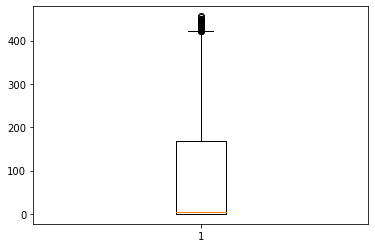

In [12]:
# Z-Score
from scipy.stats import zscore
import matplotlib.pyplot as plt

plt.boxplot(df_train['Generation'])

In [13]:
winter = df_train[df_train['Season'] == 1]
spring = df_train[df_train['Season'] == 2]
summer = df_train[df_train['Season'] == 3]
autumn = df_train[df_train['Season'] == 4]

### Winter

In [14]:
winter['Zscore_SP'] = zscore(winter.Generation)
winter[(winter.Zscore_SP > 2.5) | (winter.Zscore_SP < -2.5)]

C:\Users\asus\AppData\Local\Temp/ipykernel_10200/2725430993.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winter['Zscore_SP'] = zscore(winter.Generation)


,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,EffectiveCloudCover,Generation,Month,Day,Season,WWCode_1,WWCode_2,WWCode_3,WWCode_5,WWCode_6,WWCode_7,WWCode_8,WWCode_9,Zscore_SP
Datetime,,,,,,,,,,,,,,,,,,,
2019-02-02 11:00:00,4.0,3.7,67.4,0.5,210.0,0.0,275.315749,2,True,1,1,0,0,0,0,0,0,0,2.635813
2019-02-02 12:00:00,5.8,5.3,60.2,0.8,240.0,0.3,287.844636,2,True,1,1,0,0,0,0,0,0,0,2.781222
2019-02-02 13:00:00,7.2,6.6,55.3,1.2,253.0,0.7,275.941092,2,True,1,1,0,0,0,0,0,0,0,2.643070
2019-02-03 11:00:00,6.6,5.0,62.3,2.1,60.0,0.0,280.551003,2,True,1,1,0,0,0,0,0,0,0,2.696573
2019-02-03 12:00:00,8.5,7.9,55.1,1.5,70.0,2.6,294.187484,2,True,1,1,0,0,0,0,0,0,0,2.854837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-27 15:00:00,12.9,11.8,35.8,1.0,140.0,0.0,305.761338,2,True,1,1,0,0,0,0,0,0,0,2.989163
2021-02-28 10:00:00,5.0,4.6,64.2,1.0,230.0,0.0,309.586496,2,True,1,1,0,0,0,0,0,0,0,3.033557
2021-02-28 11:00:00,9.4,7.5,46.2,3.1,310.0,0.0,351.516081,2,True,1,1,0,0,0,0,0,0,0,3.520190


In [15]:
winter.Generation.describe()

count    5760.000000
mean       48.206991
std        86.170190
min         0.000000
25%         0.000008
50%         0.017205
75%        60.333445
max       424.672977
Name: Generation, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x286e73134c0>,
 'caps': [<matplotlib.lines.Line2D at 0x286e7313ac0>,
 'boxes': [<matplotlib.lines.Line2D at 0x286e7313130>],
 'medians': [<matplotlib.lines.Line2D at 0x286e7307220>],
 'fliers': [<matplotlib.lines.Line2D at 0x286e73075b0>],
 'means': []}

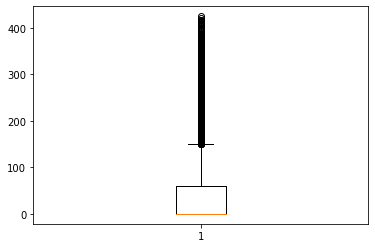

In [16]:
plt.boxplot(winter['Generation'])

In [17]:
winter = winter[winter.Generation < 75]
winter.Generation.describe()

count    4477.000000
mean        8.216447
std        17.519041
min         0.000000
25%         0.000000
50%         0.001521
75%         3.661162
max        74.958593
Name: Generation, dtype: float64

In [18]:
df_train = df_train[~((df_train['Generation'] < 75) & (df_train['Season'] == 1))]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20742 entries, 2019-01-01 10:00:00 to 2021-11-30 23:00:00
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AirTemperature       20742 non-null  float64
 1   ComfortTemperature   20742 non-null  float64
 2   RelativeHumidity     20742 non-null  float64
 3   WindSpeed            20742 non-null  float64
 4   WindDirection        20742 non-null  float64
 5   EffectiveCloudCover  20742 non-null  float64
 6   Generation           20742 non-null  float64
 7   Month                20742 non-null  int64  
 8   Day                  20742 non-null  bool   
 9   Season               20742 non-null  int64  
 10  WWCode_1             20742 non-null  uint8  
 11  WWCode_2             20742 non-null  uint8  
 12  WWCode_3             20742 non-null  uint8  
 13  WWCode_5             20742 non-null  uint8  
 14  WWCode_6             20742 non-null  uint8  
 15  W

### Spring

In [19]:
spring['Zscore_SP'] = zscore(spring.Generation)
spring[(spring.Zscore_SP > 2.5) | (spring.Zscore_SP < -2.5)]

,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,EffectiveCloudCover,Generation,Month,Day,Season,WWCode_1,WWCode_2,WWCode_3,WWCode_5,WWCode_6,WWCode_7,WWCode_8,WWCode_9,Zscore_SP
Datetime,,,,,,,,,,,,,,,,,,,
2020-04-10 12:00:00,14.3,12.4,18.1,4.1,10.0,0.0,423.727207,4,True,2,1,0,0,0,0,0,0,0,2.515877
2020-04-12 12:00:00,13.9,12.3,24.9,2.1,20.0,0.0,426.673088,4,True,2,1,0,0,0,0,0,0,0,2.538626
2020-04-12 13:00:00,15.3,13.4,19.2,2.1,20.0,0.0,424.319540,4,True,2,1,0,0,0,0,0,0,0,2.520451
2020-04-19 12:00:00,21.2,19.1,18.1,1.5,40.0,0.0,423.020496,4,True,2,1,0,0,0,0,0,0,0,2.510419
2020-04-25 12:00:00,15.6,13.9,23.0,1.5,200.0,0.0,427.034387,4,True,2,1,0,0,0,0,0,0,0,2.541416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-21 11:00:00,25.4,23.9,20.9,2.6,30.0,0.0,422.328608,5,True,2,1,0,0,0,0,0,0,0,2.505076
2021-05-21 12:00:00,27.3,24.8,14.1,4.1,20.0,0.0,425.711738,5,True,2,1,0,0,0,0,0,0,0,2.531202
2021-05-24 12:00:00,24.0,23.7,31.6,1.5,30.0,0.0,431.503869,5,True,2,1,0,0,0,0,0,0,0,2.575932


In [20]:
spring.Generation.describe()

count    6506.000000
mean       97.940289
std       129.502346
min         0.000000
25%         0.000000
50%        12.244280
75%       187.131341
max       456.319322
Name: Generation, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x286e6d7c070>,
 'caps': [<matplotlib.lines.Line2D at 0x286e6d7c670>,
 'boxes': [<matplotlib.lines.Line2D at 0x286e6d0eca0>],
 'medians': [<matplotlib.lines.Line2D at 0x286e6d7cd90>],
 'fliers': [<matplotlib.lines.Line2D at 0x286e6d88160>],
 'means': []}

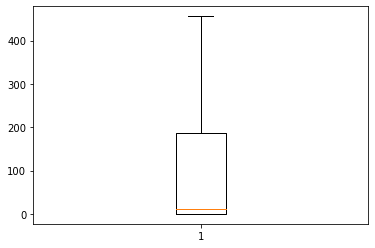

In [21]:
plt.boxplot(spring['Generation'])

### Summer

In [22]:
summer['Zscore_SP'] = zscore(summer.Generation)
summer[(summer.Zscore_SP > 2.5) | (summer.Zscore_SP < -2.5)]

,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,EffectiveCloudCover,Generation,Month,Day,Season,WWCode_1,WWCode_2,WWCode_3,WWCode_5,WWCode_6,WWCode_7,WWCode_8,WWCode_9,Zscore_SP
Datetime,,,,,,,,,,,,,,,,,,,


In [23]:
summer.Generation.describe()

count    6445.000000
mean      119.597668
std       142.617541
min         0.000000
25%         0.000008
50%        26.478028
75%       250.098758
max       441.650777
Name: Generation, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x286e6de2490>,
 'caps': [<matplotlib.lines.Line2D at 0x286e6de2be0>,
 'boxes': [<matplotlib.lines.Line2D at 0x286e6de2100>],
 'medians': [<matplotlib.lines.Line2D at 0x286e6dee340>],
 'fliers': [<matplotlib.lines.Line2D at 0x286e6dee6d0>],
 'means': []}

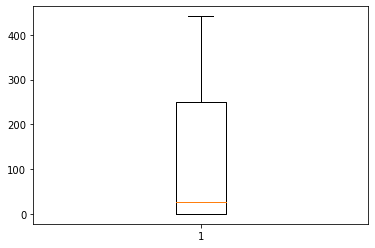

In [24]:
plt.boxplot(summer['Generation'])

### Autumn

In [25]:
autumn['Zscore_SP'] = zscore(autumn.Generation)
autumn[(autumn.Zscore_SP > 2.5) | (autumn.Zscore_SP < -2.5)]

,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,EffectiveCloudCover,Generation,Month,Day,Season,WWCode_1,WWCode_2,WWCode_3,WWCode_5,WWCode_6,WWCode_7,WWCode_8,WWCode_9,Zscore_SP
Datetime,,,,,,,,,,,,,,,,,,,
2020-09-10 12:00:00,25.9,26.5,33.7,4.1,20.0,0.0,417.240993,9,True,4,1,0,0,0,0,0,0,0,2.580794
2020-09-10 13:00:00,26.8,27.2,30.7,3.6,10.0,0.0,408.802229,9,True,4,1,0,0,0,0,0,0,0,2.514355
2020-09-15 12:00:00,27.6,25.1,14.0,3.6,10.0,0.0,411.841612,9,True,4,1,0,0,0,0,0,0,0,2.538284
2020-09-16 12:00:00,27.3,25.5,17.9,4.1,10.0,0.0,416.706822,9,True,4,1,0,0,0,0,0,0,0,2.576589
2020-09-16 13:00:00,28.8,26.8,15.9,3.6,20.0,0.0,407.446147,9,True,4,1,0,0,0,0,0,0,0,2.503678
2020-10-02 12:00:00,19.6,18.2,26.9,1.5,200.0,0.0,411.508403,10,True,4,1,0,0,0,0,0,0,0,2.535661
2021-09-04 11:00:00,21.5,21.6,39.7,1.0,20.0,1.0,412.318055,9,True,4,1,0,0,0,0,0,0,0,2.542035
2021-09-04 12:00:00,23.6,23.1,30.6,1.0,20.0,3.0,418.254436,9,True,4,1,0,0,0,0,0,0,0,2.588773
2021-09-04 13:00:00,23.5,23.1,31.7,1.5,20.0,4.0,423.596637,9,True,4,1,0,0,0,0,0,0,0,2.630833


In [26]:
autumn.Generation.describe()

count    6508.000000
mean       89.443984
std       127.023756
min         0.000000
25%         0.000000
50%         0.650633
75%       177.230606
max       441.592428
Name: Generation, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x286e717aaf0>,
 'caps': [<matplotlib.lines.Line2D at 0x286e7184250>,
 'boxes': [<matplotlib.lines.Line2D at 0x286e717a880>],
 'medians': [<matplotlib.lines.Line2D at 0x286e7184970>],
 'fliers': [<matplotlib.lines.Line2D at 0x286e7184d00>],
 'means': []}

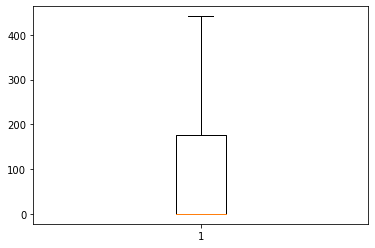

In [27]:
plt.boxplot(autumn['Generation'])

In [28]:
df_train.Generation.describe()

count    20742.000000
mean       107.559308
std        132.897449
min          0.000000
25%          0.000001
50%         23.048101
75%        212.783167
max        456.319322
Name: Generation, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x286e7226580>,
 'caps': [<matplotlib.lines.Line2D at 0x286e7226ca0>,
 'boxes': [<matplotlib.lines.Line2D at 0x286e72261f0>],
 'medians': [<matplotlib.lines.Line2D at 0x286e7232400>],
 'fliers': [<matplotlib.lines.Line2D at 0x286e7232790>],
 'means': []}

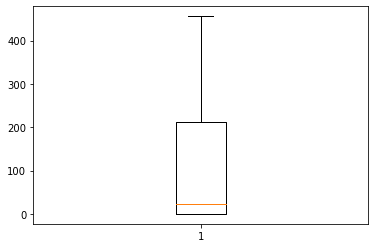

In [29]:
plt.boxplot(df_train['Generation'])

# Multicollinearity

<AxesSubplot:>

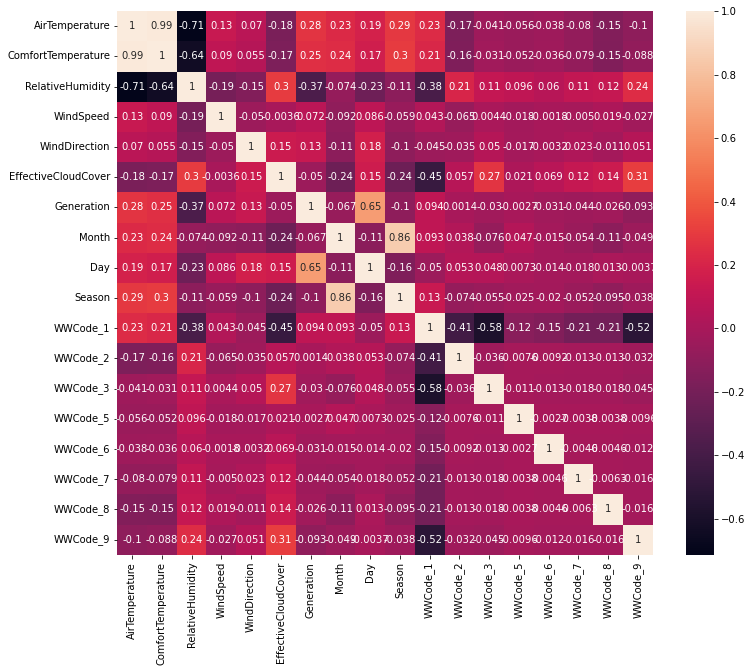

In [30]:
plt.figure(figsize=(12,10))
sn.heatmap(df_train.corr(), annot=True)

In [31]:
df_train.drop(['ComfortTemperature'], axis=1, inplace=True)
x_test.drop(['ComfortTemperature'], axis=1, inplace=True)

<AxesSubplot:>

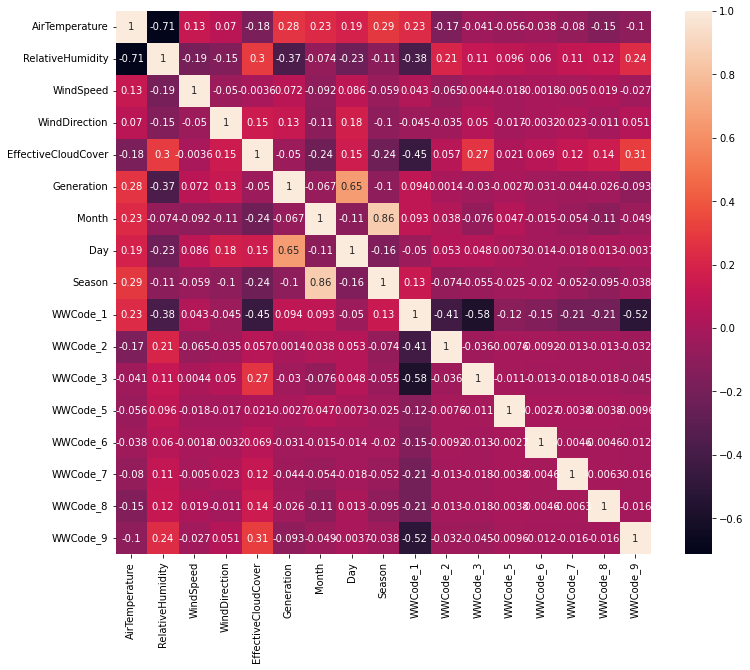

In [32]:
plt.figure(figsize=(12,10))
sn.heatmap(df_train.corr(), annot=True)

In [33]:
df_train = pd.get_dummies(df_train, columns = ['Season'])
x_test = pd.get_dummies(x_test, columns = ['Season'])

# Model Training

In [50]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import statsmodels.formula.api as sm

In [35]:
X_train = df_train.loc['2019-01-01':'2021-10-31'].drop(['Generation'], axis=1)
X_test = df_train.loc['2021-10-01':'2021-11-30'].drop(['Generation'], axis=1)
Y_train = df_train.Generation.loc['2019-01-01':'2021-10-31']
Y_test = df_train.Generation.loc['2021-10-01':'2021-11-30']

### Linear Regression

In [36]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, Y_train)

LinearRegression()

In [51]:
score = lin_reg_model.score(X_train, Y_train)
pred_val = lin_reg_model.predict(X_test)
pred_val[pred_val<0] = 0
print('Score:', score)
print("R-squared:", r2_score(Y_test, pred_val))
print('RMSE: ', mean_squared_error(Y_test, pred_val, squared=False)**(1/2))

Score: 0.492534337772904
R-squared: 0.558488308146013
RMSE:  9.122992553675287


### XGBRegressor

In [38]:
xgb_reg = XGBRegressor(random_state=42,
                     tree_method="gpu_hist",
                     gpu_id=0,predictor="gpu_predictor",
                     n_estimators=5000,)
xgb_reg.fit(X_train, Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=0, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=5000, n_jobs=8,
             num_parallel_tree=1, predictor='gpu_predictor', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [57]:
score = xgb_reg.score(X_train, Y_train)
pred_val = xgb_reg.predict(X_test)
pred_val[pred_val<0] = 0
print('Score:', score)
print("R-squared:", r2_score(Y_test, pred_val))
print('RMSE: ', mean_squared_error(Y_test, pred_val, squared=False)**(1/2))

Score: 0.9995740717292899
R-squared: 0.8459364127272626
RMSE:  7.0117555941799825


### Statsmodels

In [40]:
# sm_model = sm.OLS.fit(X_train, Y_train)

### Ridge & Lasso

In [41]:
lasso_model = Lasso(1.0)
lasso_model.fit(X_train, Y_train)

Lasso()

In [53]:
score = lasso_model.score(X_train, Y_train)
pred_val = lasso_model.predict(X_test)
pred_val[pred_val<0] = 0
print('Score:', score)
print("R-squared:", r2_score(Y_test, pred_val))
print('RMSE: ', mean_squared_error(Y_test, pred_val, squared=False)**(1/2))

Score: 0.49008917226762927
R-squared: 0.5538222057838122
RMSE:  9.147001624535273


In [43]:
ridge_model = Ridge(1.0)
ridge_model.fit(X_train, Y_train)

Ridge()

In [54]:
score = ridge_model.score(X_train, Y_train)
pred_val = ridge_model.predict(X_test)
pred_val[pred_val<0] = 0
print('Score:', score)
print("R-squared:", r2_score(Y_test, pred_val))
print('RMSE: ', mean_squared_error(Y_test, pred_val, squared=False)**(1/2))

Score: 0.49253428099367225
R-squared: 0.5584432227807973
RMSE:  9.123225445413519


### ElasticNet

In [45]:
elastic_model = ElasticNet(1.0, l1_ratio = 1.0)
elastic_model.fit(X_train, Y_train)

ElasticNet(l1_ratio=1.0)

In [55]:
score = elastic_model.score(X_train, Y_train)
pred_val = elastic_model.predict(X_test)
pred_val[pred_val<0] = 0
print('Score:', score)
print("R-squared:", r2_score(Y_test, pred_val))
print('RMSE: ', mean_squared_error(Y_test, pred_val, squared=False)**(1/2))

Score: 0.49008917226762927
R-squared: 0.5538222057838122
RMSE:  9.147001624535273


### Decision Tree Regressor

In [47]:
dt_reg = DecisionTreeRegressor(max_depth=27,
                              min_samples_leaf=1,
                              random_state=3)
dt_reg.fit(X_train, Y_train)

DecisionTreeRegressor(max_depth=27, random_state=3)

In [56]:
score = dt_reg.score(X_train, Y_train)
pred_val = dt_reg.predict(X_test)
pred_val[pred_val<0] = 0
print('Score:', score)
print("R-squared:", r2_score(Y_test, pred_val))
print('RMSE: ', mean_squared_error(Y_test, pred_val, squared=False)**(1/2))

Score: 0.9986441261579241
R-squared: 0.7516416915401403
RMSE:  7.9008067902352055


In [63]:
df = true_false(x_test)
df[df.Day == 1]

,AirTemperature,RelativeHumidity,WindSpeed,WindDirection,EffectiveCloudCover,Month,Day,WWCode_1,WWCode_2,WWCode_3,WWCode_5,WWCode_6,WWCode_7,WWCode_8,WWCode_9,Season_1
Datetime,,,,,,,,,,,,,,,,
2021-12-01 07:00:00,2.6,87.3,1.0,240.0,5.0,12,1,0,0,0,0,0,0,0,1,1
2021-12-01 08:00:00,2.4,89.8,1.0,210.0,4.5,12,1,1,0,0,0,0,0,0,0,1
2021-12-01 09:00:00,2.6,85.4,1.0,200.0,5.7,12,1,1,0,0,0,0,0,0,0,1
2021-12-01 10:00:00,3.2,79.5,1.0,250.0,4.5,12,1,1,0,0,0,0,0,0,0,1
2021-12-01 11:00:00,3.5,79.0,1.5,230.0,4.5,12,1,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 13:00:00,9.9,57.1,0.5,100.0,1.5,12,1,1,0,0,0,0,0,0,0,1
2021-12-31 14:00:00,11.4,48.8,0.5,150.0,1.5,12,1,1,0,0,0,0,0,0,0,1
2021-12-31 15:00:00,12.1,47.6,0.5,220.0,1.2,12,1,1,0,0,0,0,0,0,0,1
